# Imports

In [1]:
!git clone https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models

Cloning into 'TensorFlow-Advanced-Segmentation-Models'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 677 (delta 45), reused 31 (delta 20), pack-reused 605
Receiving objects: 100% (677/677), 3.97 MiB | 29.67 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [2]:
%cd TensorFlow-Advanced-Segmentation-Models
import tensorflow_advanced_segmentation_models as tasm
%cd ..

/content/TensorFlow-Advanced-Segmentation-Models
/content


In [3]:
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
from IPython.display import clear_output

## Download the Oxford-IIIT Pets dataset & Perform Augmentation

In [4]:
# dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
dataset, info = tfds.load("caltech_birds2010", with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incomplete6DEBVS/caltech_birds2010-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incomplete6DEBVS/caltech_birds2010-test.tfrecord


Dataset caltech_birds2010 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.


In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_mask

In [6]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [7]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

## Define some global variables

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
N_CLASSES = 2
HEIGHT = 320
WIDTH = 320
BACKBONE_NAME = "efficientnetb5"
WEIGHTS = "imagenet"

In [9]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

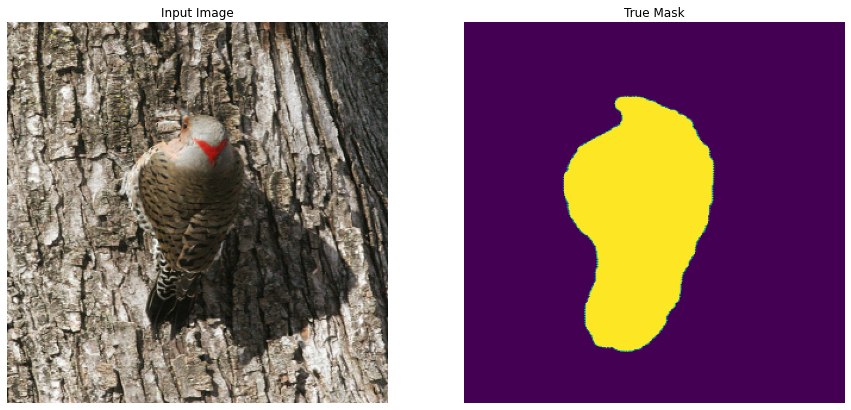

In [12]:
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    
display([sample_image, sample_mask])

# Create the Model

In [13]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
model = tasm.ACFNet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

115269632/115263384 [==============================] - 1s 0us/step


### Define the optimizer as well as losses, metrics and callbacks

In [14]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)

metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=7, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=19, mode="max", verbose=1, restore_best_weights=True)
]

In [51]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    # for yet unknown reasons 0s and 1s need to be inverted... something is not working properly in the training pipeline
    # that is why iou_score and val_iou_score are so low while fitting the model...
    pred_mask = pred_mask == 0
    pred_mask = tf.cast(pred_mask, tf.float32)
    return pred_mask[0]

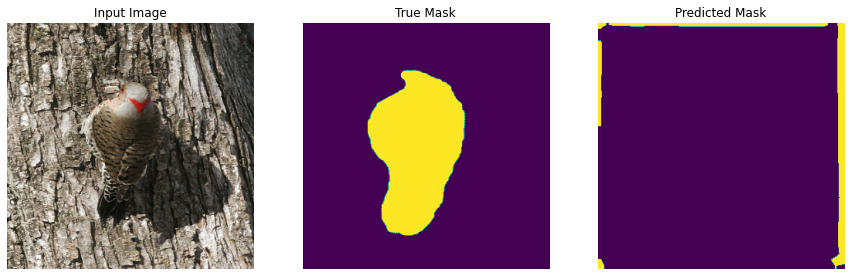

In [17]:
display([
         sample_image,
         sample_mask,
         create_mask(
             model.predict(sample_image[tf.newaxis, ...])
             )
         ])

# Training

## Training Procedure

##### 1) Train model with freezed backbone only on train data
##### 2) Train completly unfreezed model with train and validation data

### 1) Train model with freezed backbone only on train data

Set Backbone trainable to False.

In [18]:
for layer in model.layers:
    if "model" in layer.name:
        layer.trainable = False

    print(layer.name + ": " + str(layer.trainable))

model: False
atrous_spatial_pyramid_pooling_v3: True
dropout: True
convolution_bn_activation_1: True
dropout_1: True
convolution_bn_activation_2: True
att_cf__module: True
concatenate: True
convolution_bn_activation_3: True
dropout_2: True
convolution_bn_activation_4: True
up_sampling2d: True


In [19]:
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    # validation_steps=VALIDATION_STEPS,
    # validation_data=test_dataset,
    callbacks=callbacks
    )

Epoch 1/100
187/187 [==============================] - 122s 623ms/step - loss: 0.8831 - iou_score: 0.1845
Epoch 2/100
187/187 [==============================] - 118s 630ms/step - loss: 0.8170 - iou_score: 0.2526
Epoch 3/100
187/187 [==============================] - 118s 629ms/step - loss: 0.7926 - iou_score: 0.2611
Epoch 4/100
187/187 [==============================] - 117s 626ms/step - loss: 0.7788 - iou_score: 0.2620
Epoch 5/100
187/187 [==============================] - 118s 628ms/step - loss: 0.7665 - iou_score: 0.2654
Epoch 6/100
187/187 [==============================] - 117s 628ms/step - loss: 0.7516 - iou_score: 0.2689
Epoch 7/100
187/187 [==============================] - 117s 627ms/step - loss: 0.7403 - iou_score: 0.2742
Epoch 8/100
187/187 [==============================] - 117s 627ms/step - loss: 0.7374 - iou_score: 0.2682
Epoch 9/100
187/187 [==============================] - 117s 627ms/step - loss: 0.7290 - iou_score: 0.2706
Epoch 10/100
187/187 [========================

2) Train completly unfreezed model with train and test data

<p>Make whole model trainable and additionally use validation set.</p>

In [20]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

model: True
atrous_spatial_pyramid_pooling_v3: True
dropout: True
convolution_bn_activation_1: True
dropout_1: True
convolution_bn_activation_2: True
att_cf__module: True
concatenate: True
convolution_bn_activation_3: True
dropout_2: True
convolution_bn_activation_4: True
up_sampling2d: True


In [21]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [22]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=callbacks
    )

Epoch 1/100
187/187 [==============================] - 143s 766ms/step - loss: 0.6785 - iou_score: 0.2885 - val_loss: 0.9802 - val_iou_score: 0.0835
Epoch 2/100
187/187 [==============================] - 142s 760ms/step - loss: 0.6322 - iou_score: 0.3454 - val_loss: 1.0504 - val_iou_score: 0.0811
Epoch 3/100
187/187 [==============================] - 141s 757ms/step - loss: 0.6207 - iou_score: 0.3603 - val_loss: 0.8066 - val_iou_score: 0.1317
Epoch 4/100
187/187 [==============================] - 142s 757ms/step - loss: 0.6147 - iou_score: 0.3682 - val_loss: 0.7521 - val_iou_score: 0.1919
Epoch 5/100
187/187 [==============================] - 142s 758ms/step - loss: 0.6089 - iou_score: 0.3755 - val_loss: 0.6995 - val_iou_score: 0.2641
Epoch 6/100
187/187 [==============================] - 142s 759ms/step - loss: 0.6062 - iou_score: 0.3794 - val_loss: 0.8169 - val_iou_score: 0.1219
Epoch 7/100
187/187 [==============================] - 142s 758ms/step - loss: 0.6020 - iou_score: 0.3841 

### Plot Training IoU Scores and Losses

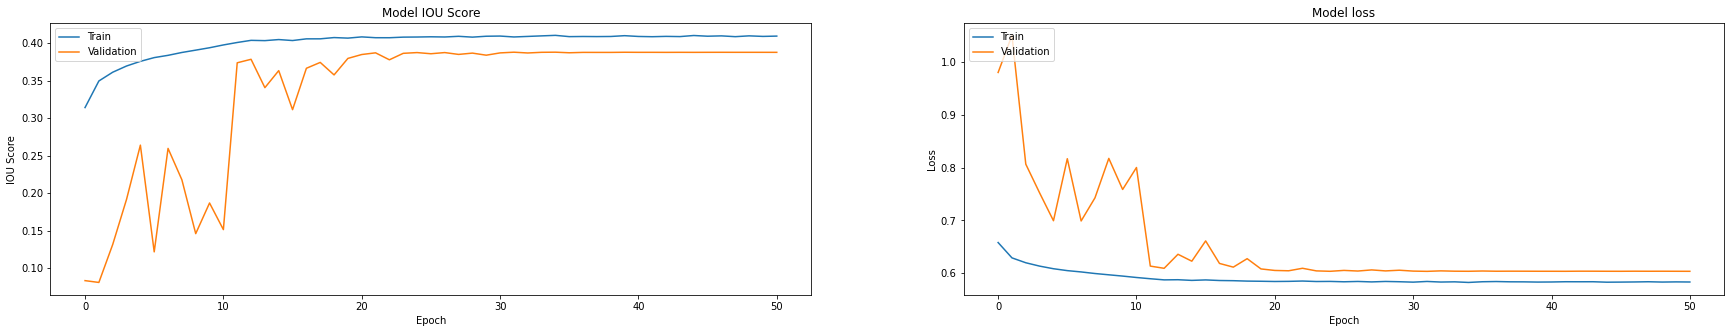

In [24]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Visual Examples on Test Data

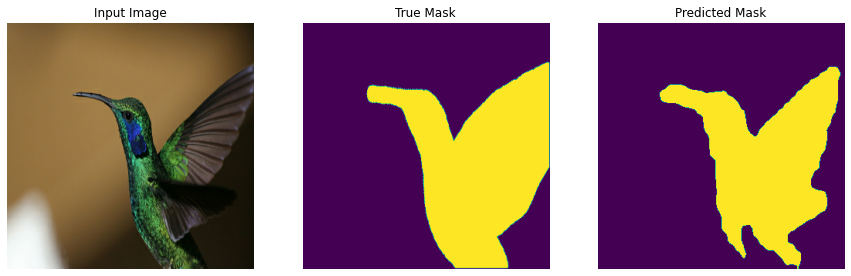

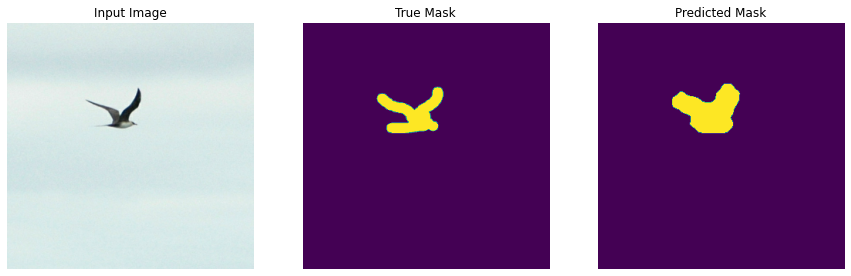

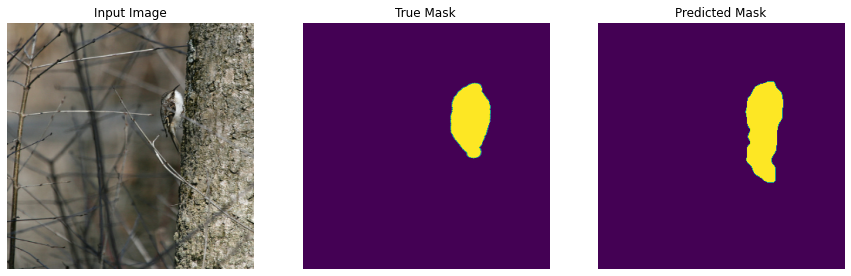

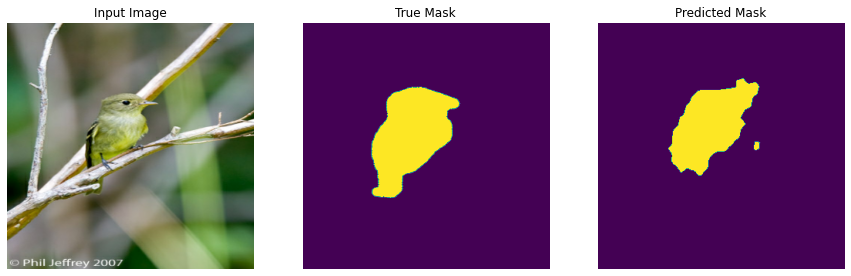

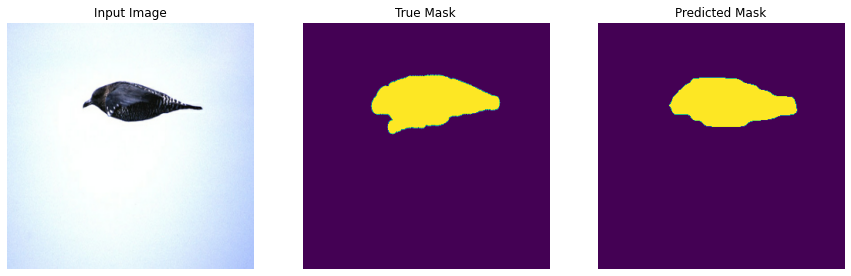

In [65]:
iou_scores = 0

for image, mask in test.take(5):
    sample_image, sample_mask = image, mask

    output_model = model.predict(sample_image[tf.newaxis, ...])
    
    display([
                sample_image,
                sample_mask,
                create_mask(output_model)
                ])
    # print(create_mask(output_model))

### Manually Calculating Test IoU-Score on 2500 images

In [64]:
iou_scores = 0

for image, mask in test.take(2500):
    sample_image, sample_mask = image, mask

    output_model = model.predict(sample_image[tf.newaxis, ...])
    
    iou_score = tasm.losses.iou_score(sample_mask, create_mask(output_model)).numpy()
    iou_scores += iou_score

print("Mean IoU-Score: " + str(iou_scores / 2500))

Mean IoU-Score: 0.802595785021782
